------------------------------------------------------
*Applications of Machine Learning*
------------------------------------------------------

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es*

In [1]:
from IPython.core.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt




After dealing with a variety of problems with our dataset, from  normalizing data at different scales, identifying missing values  and deteting outliers, we can start to make big decisions such as, at what point is a feature actually relevant for the final task. Which columns are not helping my ML pipeline and therefore are hurting my pipeline and should be removed? 

This session focuses on **feature selection techniques** used to make the decision of which attributes to get rid of in our dataset. We will explore several statistical and iterative processes that will aid us in this decision.

# Feature Selection

The goal of Feature Selection (FS) is to find the subset of those feature which are relevant (informative) and needed to solve the task. Its application in a ML pipeline has several advantages:
* From the point of view of training, it can provide computational cost reductions and performance improvements.
* It also provides a gain in interpretation of the problem itself. 
* Additionally, in some applications, it prodives savings in the feature obtation process since it avoids the extraction of useless features.

The FS techniques are divided into three groups:

1. **Filtering methods**: The FS proccess is independent of the subsequent classification/regression stage. This is the case of using independent relevance criteria such as the correlation, MI, ...
2. **Wrappers**: use the final classification/regression performance (over a CV partition) to select the best subset of features. For example, a RFE approach evaluating the feature to remove with the CV performance of the ML model.
3. **Embedded**: the FS process is integrated into the training of the final classifier/regressor. This is the case of ML models with L1 regularization.


<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/FeatureSelection/FS_1en.png" width="40%">

Throughout this notebook, we are going to introduce these three FS strategies; to do so, we will work with a car price prediction problem. So let's start by loading and preparing the data.


## Loading data 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv("http://www.tsc.uc3m.es/~vanessa/data_notebooks/autos/autos.csv")

df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [3]:
X = df.copy()
y = X.pop("price")

In [4]:
v_cat = [element for element in X.dtypes[(X.dtypes=='O')].index.values]
no_v_cat = [element for element in X.dtypes[(X.dtypes!='O')].index.values]
print(v_cat)

['make', 'fuel_type', 'aspiration', 'body_style', 'drive_wheels', 'engine_location', 'engine_type', 'fuel_system']


In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(X[v_cat])

Xcat = enc.transform(X[v_cat]).toarray()

Xcat = pd.DataFrame(Xcat, columns=enc.get_feature_names(v_cat)).astype('int64')

X = pd.concat([X[no_v_cat], Xcat], axis=1) 
X.head()

,symboling,num_of_doors,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,...,engine_type_ohc,engine_type_ohcf,engine_type_ohcv,fuel_system_1bbl,fuel_system_2bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi
0,3,2,88.6,168.8,64.1,48.8,2548,4,130,3.47,...,0,0,0,0,0,0,0,1,0,0
1,3,2,88.6,168.8,64.1,48.8,2548,4,130,3.47,...,0,0,0,0,0,0,0,1,0,0
2,1,2,94.5,171.2,65.5,52.4,2823,6,152,2.68,...,0,0,1,0,0,0,0,1,0,0
3,2,4,99.8,176.6,66.2,54.3,2337,4,109,3.19,...,1,0,0,0,0,0,0,1,0,0
4,2,4,99.4,176.6,66.4,54.3,2824,5,136,3.19,...,1,0,0,0,0,0,0,1,0,0


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# split into a training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.4, random_state=25)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to np arrays
Y_train =  Y_train.values
Y_test =  Y_test.values

# 1. Filtering methods

Filtering methods are characterized for being independent from the subsequent learning stage, so they use a relevance criterion to measure the discriminatory/regression capability of each feature and select or rank the input features according this criterion.

As **relevance criteria** we can find:
* Variance (unsupervised)
* Correlation coefficient (regression). This relevance criterion is implemented in the [f_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) method of sklearn.
* Statistical tests: t-test (binary), F-test (multiclass), chi-square (categorical feat). These tests consist of evaluating whether the data of the different classes have been generated by different distributions or not. These tests can be found implemented in sklearn in these methods:
  * [f_classif](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html): method to obtain the F-score between each input feature and the classification task to be solved.   In particular, this test is reduced to a t-test when working with binary problems.
  * [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2): function to obtain the chi2-scores. Its operation is similar to that of the F-score, but specifically designed for categorical input features.
* Mutual Information. We will now look at this criterion in detail and explain the functions available to implement it.
* Gini index (used by decision trees and random forests).

Next, let's see how to use some of these criteria using the sklearn funcionalities.


## Ranking the variables with Mutual Information 

 Mutual information (MI) is capable of measuring any type of relationship between two random variables, unlike correlation which only detects linear relationships. Formally, if we have two r.v. $X$ and $Y$, the mutual information is given by:

$$ MI (X, Y) = \int \int p_{X,Y}(x,y) \log{\frac{p_{X,Y}(x,y)}{p_{X}(x)p_{Y}(y)}} $$
where $p_{X,Y}(x,y)$ is the joint distribution between $X$ and $Y$ and $p_{X}(x)$ and $p_{Y}(y)$ are their marginal distribution. 
The smallest possible mutual information between quantities is 0, which occurs when $X$ and $Y$ are independent. Conversely, in theory there is no upper bound for MI, but in practice, values greater than 2 are rare. Mutual information is a logarithmic quantity, so it increases very slowly.
 


**What information does MI provide?**

MI describes relationships in terms of **uncertainty**. The MI between two quantities is a measure of the degree to which knowledge of one quantity reduces the uncertainty about the other. If you knew the value of a feature, how much more certain would you be about the target?

Let's look at this figure showing the price (`price`) of our cars as a function of their make (`make`):


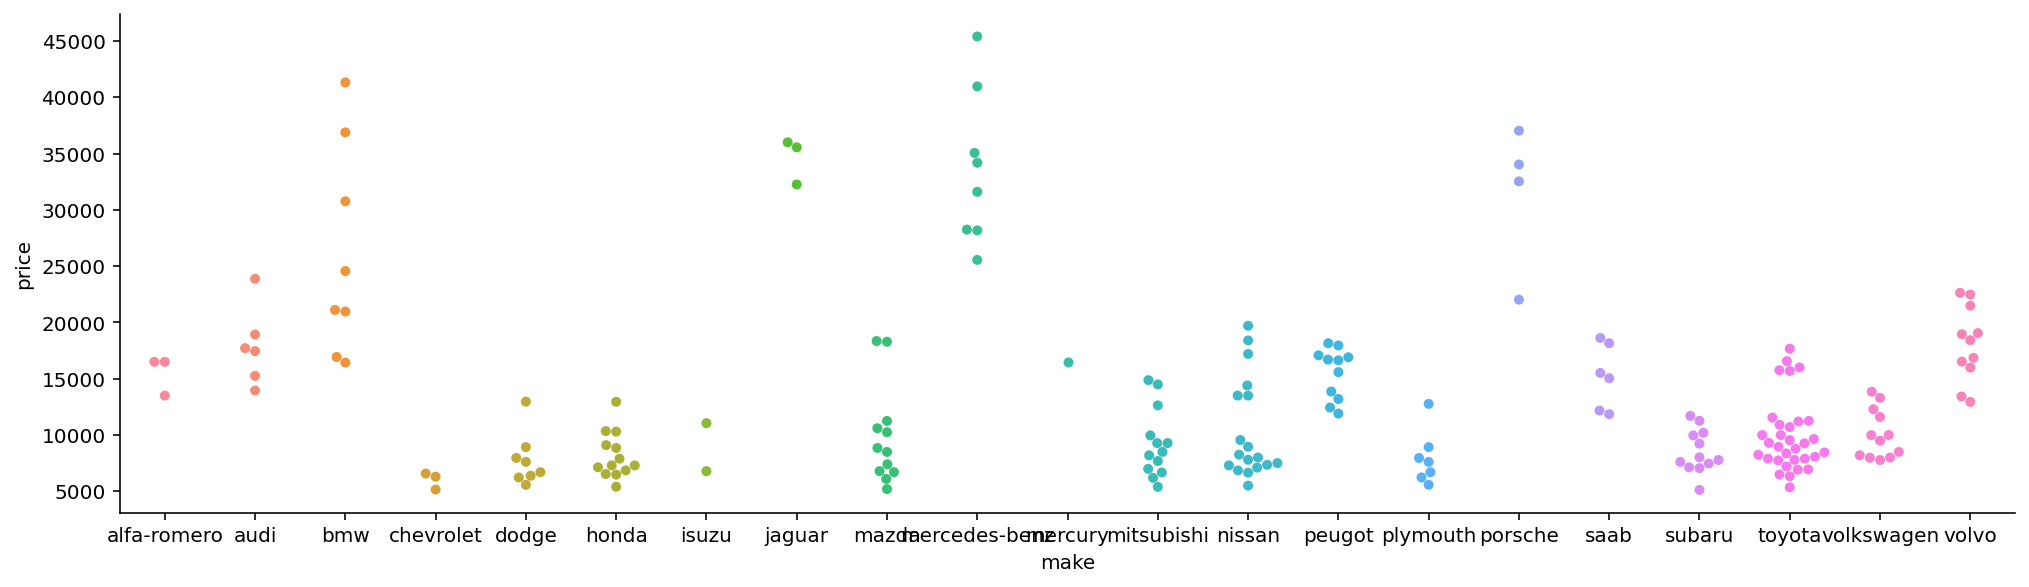

In [7]:
sns.catplot(data=df, kind="swarm", x="make", y="price", hue="make", height=4, aspect=3.5)

As we can see, knowing the car model should give more certainty about the `Price` value: each `make` category tends to concentrate the price within a certain range. The mutual information that `make` has with `Price` is the average reduction in uncertainty in the selling price for each of the `make` values. Since, for example, `alpha-romero` occurs less frequently than `toyota`, `alpha-romero` has less weight in the MI value.

Moreover, as we have said, MI is capable of measuring any kind of relationship between $X$ and $Y$, in addition to measuring the degree of relationship. To see this, the following figure shows different types of relationships and the associated MI values

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/FeatureSelection/MI2.png" width="80%"> 

The figure on the left shows different variables (with different colours) and we can see that as the dependence of the input variable on the output variable is tighter (the uncertainty is reduced), the value of MI is higher.

On the other hand, the figure on the right shows how MI can capture any type of relationship (not only linear, such as correlation). 

**Calculation and implementation of the value of MI**.

As we have indicated, the value of MI is given by this expression:


$$ MI (X, Y) = \int p_{X,Y}(x,y) \log{\frac{p_{X,Y}(x,y)}{p_{X}(x)p_{Y}(y)}} $$

The main problem in obtaining the MI value is based on knowing these (usually unknown) probability distributions; thus, most implementations use MI estimators based on data histograms, Parzen windowing approaches or K-NN-based density estimates. In particular, sklearn's MI implementation uses K-NN-based estimation. 

In fact, scikit-learn has two mutual information metrics in its `feature_selection` module: one for real target variables ([mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)) and one for categorical ([mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)). 


Our target, `price`, is real-valued, so we will use [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html). To use this function, there are two things to be aware of:
* This function has a parameter (`k`:number of neighbours) that should be set by cross-validation; however, to reduce computation time in this example, we will use its default value.
* You have to specify to the function which variables are continuous and which are discrete. Here we use the term "discrete" instead of "categorical", because we refer to categorical variables (which turn out to be discrete after encoding with e.g. one-hot-encoding) and discrete variables as such. For example, the pixel intensities of an image are discrete (but not categorical) features. The implementation of this function will get better results if we specifically tell it these variables, as treating a continuous variable as discrete and vice versa often gives incorrect results, so we should be aware of this.

The following cells compute the MI scores for our characteristics and analyze the results


In [8]:
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

discrete_features

symboling           False
num_of_doors        False
wheel_base          False
length              False
width               False
                    ...  
fuel_system_idi     False
fuel_system_mfi     False
fuel_system_mpfi    False
fuel_system_spdi    False
fuel_system_spfi    False
Length: 63, dtype: bool

In [9]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X_train, Y_train, discrete_features=discrete_features)
ind_rel_feat = np.argsort(mi_scores)[::-1]
mi_scores = pd.Series(mi_scores[ind_rel_feat], index =X.columns[ind_rel_feat]) 
mi_scores

highway_mpg         0.895577
engine_size         0.870089
curb_weight         0.861911
horsepower          0.819066
city_mpg            0.807427
                      ...   
engine_type_ohcf    0.000000
engine_type_ohcv    0.000000
make_mercury        0.000000
make_saab           0.000000
num_of_doors        0.000000
Length: 63, dtype: float64

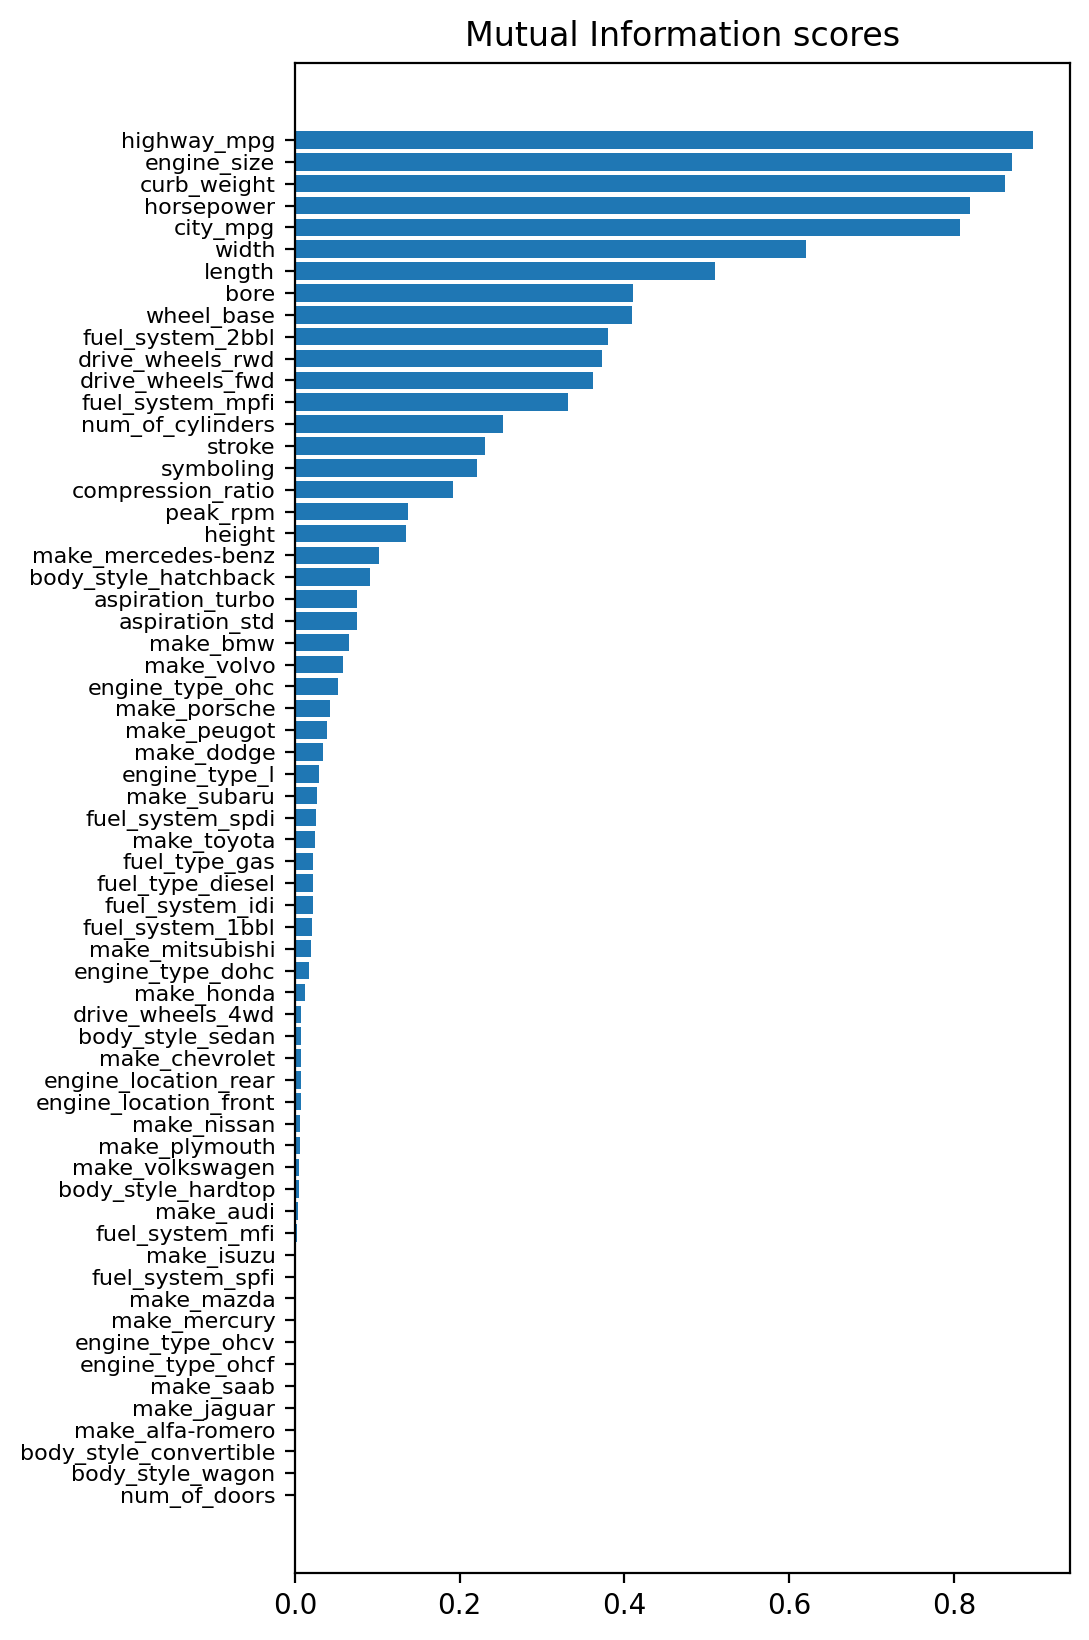

In [10]:
def plot_utility_scores(scores, title):
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.barh(width, y)
    plt.yticks(width, ticks)
    plt.title(title)


plt.figure(dpi=100, figsize=(5, 10))
plt.rc('ytick', labelsize=8) 
plot_utility_scores(mi_scores, title="Mutual Information scores")


#### Analysis of relationships between variables

From the obtained  MI values, the data visualization can help us to analyze the relationships between the variables. Let's take a look at the relationship between the output variable and the variables `curb_weight` and `horsepower`, which have the highest MI.

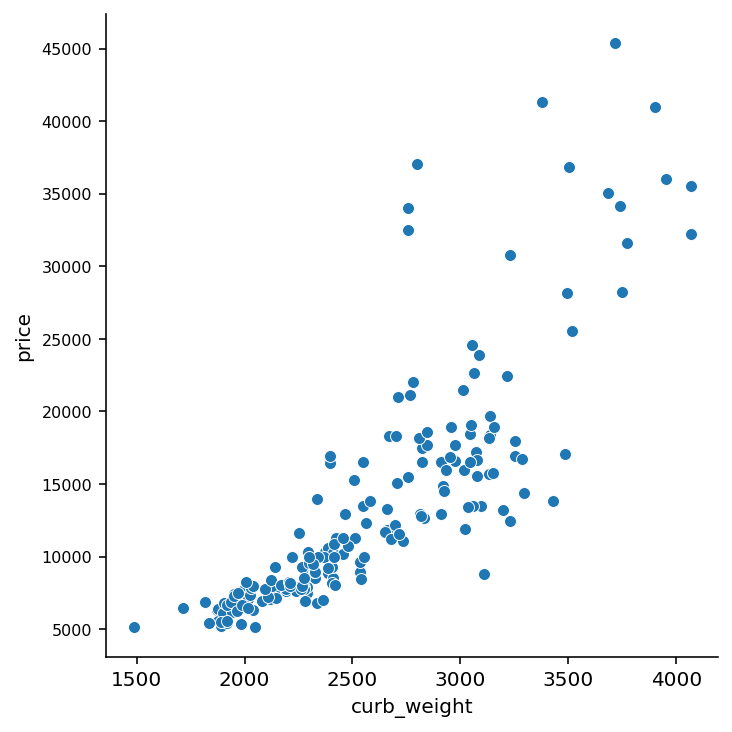

In [11]:
sns.relplot(x="curb_weight", y="price", data=df)

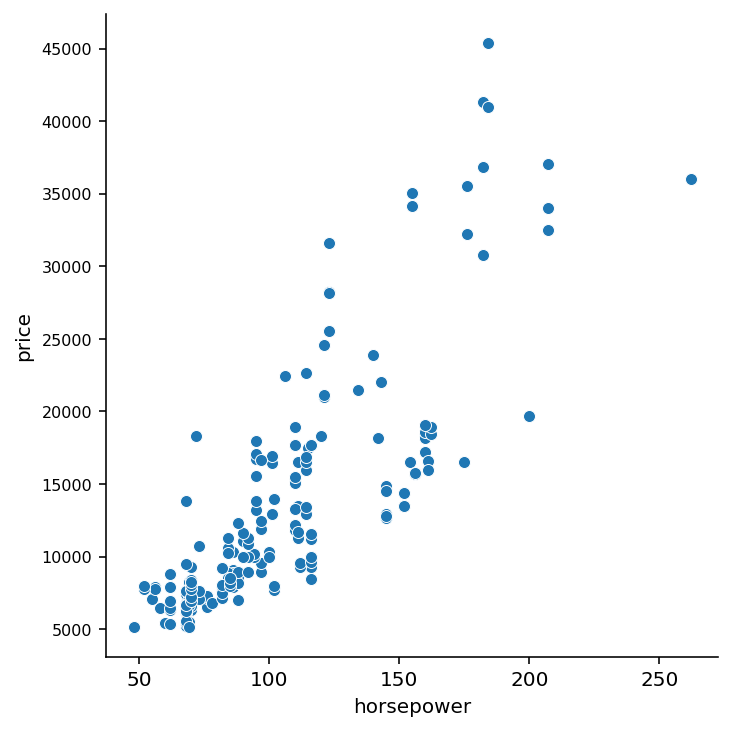

In [12]:
sns.relplot(x="horsepower", y="price", data=df)

In both cases we find that these variables can be very useful in the estimatation of `price`.

On the other hand, `fuel_type_diesel` or `fuel_type_gas` (one is complementary to the other) have a rather low MI value, which makes us assume that they are not going to be of help and we could discard them... but if we draw them together with `horsepower`...

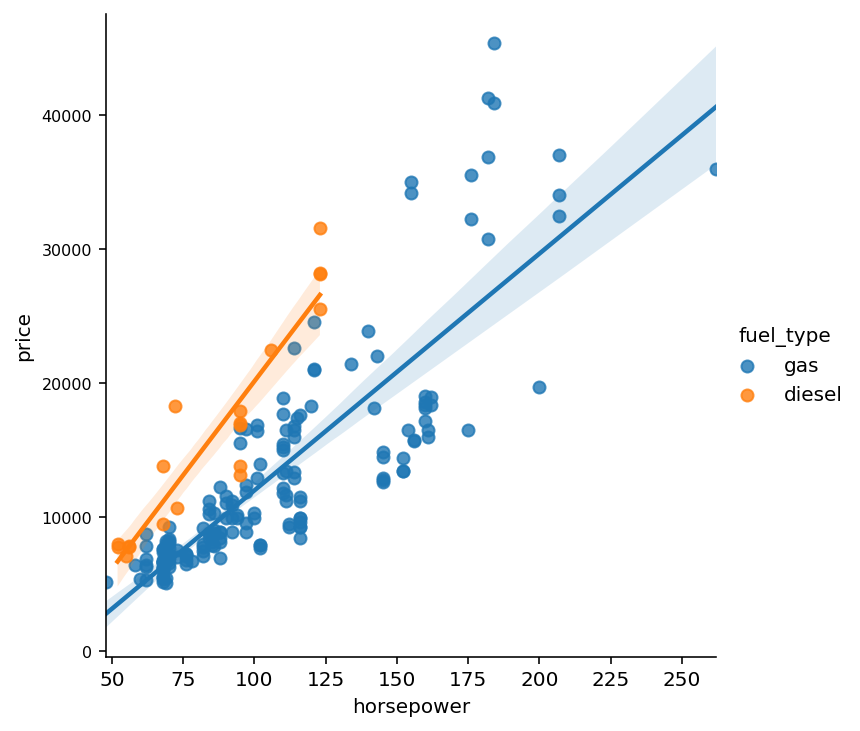

In [13]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

We can see that `fuel_type` clearly separates two price populations with different trends within `horsepower`. This indicates that `fuel_type` contributes to an interaction effect and might not be unimportant after all. Before deciding that a feature is not important on the basis of its MI score, it is good to investigate any possible interaction effects: domain knowledge can offer a lot of guidance in this respect. 


On the other hand, this analysis of variables can help us choose the most appropriate model. If we visualize the relationship between `highway_mpg` and `price`, what would you use to solve the problem, a linear or a non-linear model?

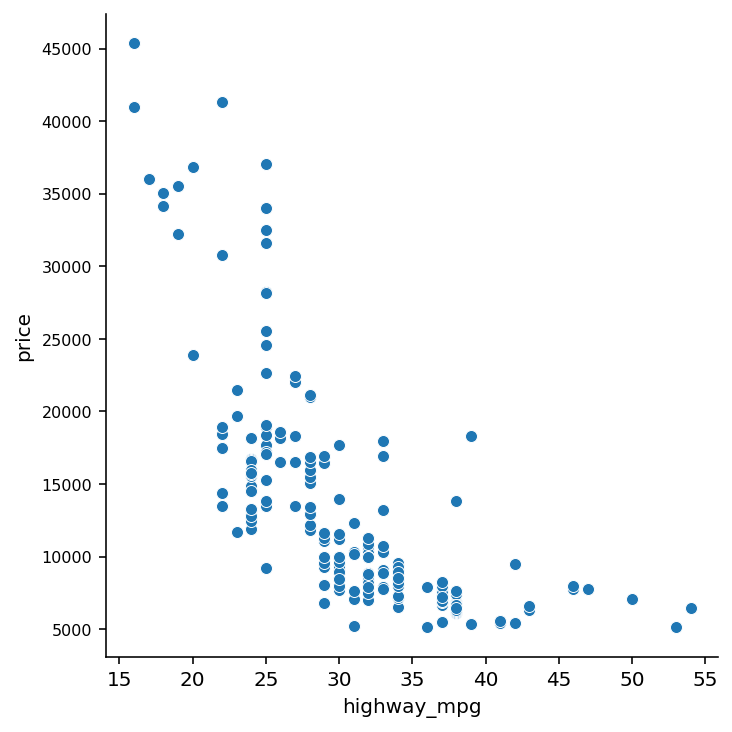

In [14]:
sns.relplot(x="highway_mpg", y="price", data=df)

We see that a linear model is not the best option and that simply a polynomial transformation of order 2 on `highway_mpg` can give us a big advantage.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Modelo de regresión lineal
ind_sel = np.where(X.columns=='highway_mpg')[0][0]

LR = LinearRegression(fit_intercept='True').fit(X_train[:, ind_sel][:,np.newaxis], Y_train)
score_LR = LR.score(X_test[:, ind_sel][:,np.newaxis], Y_test)


print("The test R2 with LR is:", score_LR)

# Modelo no lineal
# definamos el grado del polinomio a grado 2
degree =2

# Definimos el pipeline con sus pasos
PolyReg_pipeline = Pipeline(steps=[('Poly', PolynomialFeatures(degree)), ('Norm', StandardScaler()), ('LR', LinearRegression(fit_intercept='True'))])

PolyReg_pipeline.fit(X_train[:, ind_sel][:,np.newaxis], Y_train)
score_LR = PolyReg_pipeline.score(X_test[:, ind_sel][:,np.newaxis], Y_test)
print("The test R2 with poly degree 2 is:", score_LR)

The test R2 with LR is: 0.4692058236798581
The test R2 with poly degree 2 is: 0.7297616153102642


#### Ranking of features

Now, we can use this ranking and analyze the performance of a regressor according to the number of variables we use...

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

def R2_evolution(X_train_s, Y_train, X_test_s, Y_test, rang_feat):
    """Compute the R2 over validation and test data for different the number of features given
        in rang_feat.

    Args:
        X_train_s (numpy dnarray): training data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number data x 1).
        X_test_s (numpy dnarray): test data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number data x 1).
        rang_feat: range with different number of features to be evaluated                                           
   
    """
    
    # Define the model to train and adjust by CV the free parameters
    model = KNeighborsRegressor()
    R2_val = []
    R2_test = []
    param_grid = {
    'n_neighbors': range(1,10),
    'weights':['uniform','distance'],
    }
    grid= GridSearchCV(model, param_grid, cv=10)

    for i in rang_feat:
        # Train SVM classifier
        grid.fit(X_train_s[:, :i], Y_train)
        # Compute R2
        R2_val.append(grid.best_score_)
        R2_test.append(grid.score(X_test_s[:, :i], Y_test))

    return np.array(R2_val), np.array(R2_test)


def plot_R2_evolution(rang_feat, R2_val, R2_test):

    """Plot the R2 evolution for training, validation and test data sets.
    Args:
        rang_feat: range with different number of features where the R2 has been evaluated   
        R2_val: numpy vector with the validation R2
        R2_test: numpy vector with the test R2                                       
    """

    plt.plot(rang_feat, R2_val, "b", label="validation")
    plt.plot(rang_feat, R2_test, "r", label="test")
    plt.xlabel("Number of features")
    plt.ylabel("R2")
    plt.title('R2 evolution')
    plt.legend(['Validation', 'Test'], loc = 4)

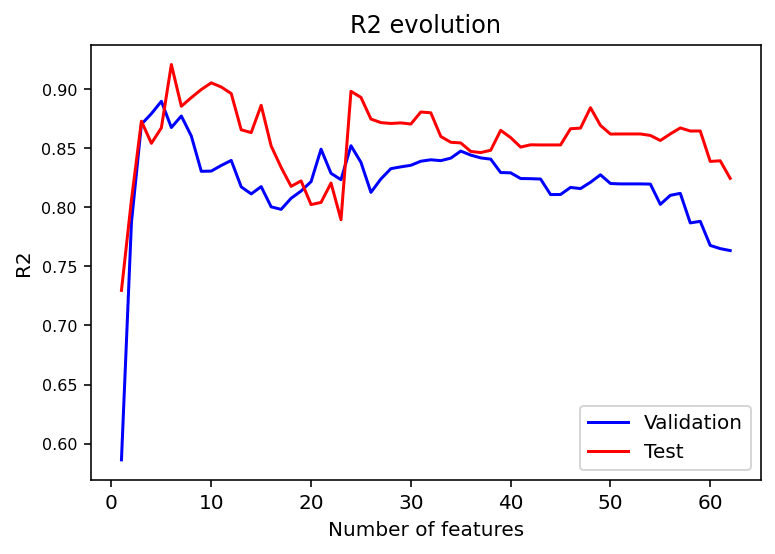

Number selected of features:  5
The test R2 is  0.87


In [17]:
# Define the range of features to explore
rang_feat = np.arange(1, X.shape[1]) 
[R2_val, R2_test] = R2_evolution(X_train[:, ind_rel_feat], Y_train, X_test[:, ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_R2_evolution(rang_feat, R2_val, R2_test)
plt.show()

# Find the CV number of features
pos_max = np.argmax(R2_val)
num_feat = rang_feat[pos_max]
test_R2 = R2_test[pos_max]

print('Number selected of features:  %d' %(num_feat))
print("The test R2 is  %2.2f" %(test_R2))

We can also include feature selection in a pipeline using [`SelectBestK()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) and cross validate the different parameters with `GridSearch`.

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
param_grid = {
    'FS__k' : range(10, 60, 10),
    'KNN__n_neighbors': range(5,10,2),
    'KNN__weights':['uniform'],#['uniform','distance'],
    }

def my_score(X, y):
    return mutual_info_regression(X, y, discrete_features=discrete_features) 


pipe = Pipeline([('FS', SelectKBest(my_score)), ('KNN', KNeighborsRegressor())])
grid_pipe = GridSearchCV(pipe, param_grid, cv=10)
grid_pipe.fit(X_train, Y_train)
print(grid_pipe.best_params_)

R2_test = grid_pipe.score(X_test, Y_test)
print("R2 over test data: {0:.2f}".format(R2_test))

{'FS__k': 40, 'KNN__n_neighbors': 5, 'KNN__weights': 'uniform'}
R2 over test data: 0.84


**Summary:** 

Mutual information is a great general-purpose metric and especially useful for feature selection and even for feature analysis, when it may not yet be known which model will be used. It is also...

* easy to use and interpret,
* computationally efficient,
* theoretically well-founded, and
* able to detect any kind of relationship.

However, when we are going to use it, we must take into account:
* Mutual information can tell us the individual potential of each feature to predict our target variable.
* It is possible for a feature to be very informative when interacting with other features, but not so informative on its own. MI cannot detect interactions between features. It is a **univariate** metric (at least with the current sklearn implementation).
* The actual usefulness of a feature depends on the model with which it is used. A feature is only useful if our model can learn its relationship with the target. Just because a feature has a high MI score does not mean that your model can do anything with that information. You may need to transform the feature first to expose the association.



## Multivariate criteria

Previous examples show that it is reasonable selecting subsets of variables that together have good predictive power, as opposed to ranking variables according to their individual predictive power. For this purpose, we need **mutivariate criteria**. 



### Minimum Redundancy Maximal Relevance method (mrMR)

The mrMR method is a strategy for using univariate scores in a multivariate analysis. The idea of this scheme is based on the use of forward search in which at each step we add the feature that is most relevant (with the output task) and has the least redundancy with the features already selected. 

We can summarize its working with the following pseudocode:
1. Select relevance and redundancy scorings ($R_{\rm REL}$, $R_{\rm RED}$)
2. Define $var_{\rm sel} = \left\lbrace \right\rbrace $; $var_{\rm  cand} =\left\lbrace X_1, \ldots, X_D\right\rbrace$
3. Loop over $D$ iterations:
  
  3.1. Loop i over $var_{\rm  cand}$ and compute:
    $$ {\rm Relevance}(i) = R_{\rm REL} \left(X_i, Y\right) $$
$$ {\rm Redundancy}(i) =\displaystyle \sum_{i' \in var_{\rm sel}}  R_{\rm RED} \left(X_i, X_{i'}\right) $$
$${\rm mrMR}(i)= {\rm Relevance}(i) - {\rm Redundancy}(i)$$

  3.2. Compute 
$$i^{*} = \underset{i}{\operatorname{argmax}} ~{\rm mrMR}(i)$$ 
  3.3 Add $i^{*}$ to $var_{\rm sel}$ and remove from $var_{\rm  cand}$.

Let's see how to apply this method using **mutual information** as a criterion of relevance and **correlation** as a measure of redundancy.

In [19]:
# Variable initialization
n_var = X_train.shape[1]
var_sel = np.empty(0,dtype=int) # subset of selected features
var_cand = np.arange(n_var) # subset of candidate features
# Precompute relevances 
relevances = mutual_info_regression(X_train, Y_train, discrete_features=discrete_features)
# Precomupute redundancies (correlation among all input variables, it is a matrix of n_var x n_var)
redundancies = np.abs(np.cov(X_train.T))
# Select the most relevant feature
sel = np.argmax(relevances)
# Add it to the subset of selected features
var_sel = np.hstack([var_sel,sel])
# Remove it from the subset of candidate features
var_cand = np.delete(var_cand,sel)
MRmr_values= [relevances[sel]]
# Iteratively select variables
for i in range(n_var-1):
    # Get relevance values of the var_cand variables
    relevances_cand=relevances[var_cand]
    # Compute redundancies with selected features:
    # from the redundancies matrix select the rows of var_sel and the columns of var_cand
    redundancy_sel = redundancies[np.ix_(var_sel,var_cand)]    
    # Average the redundancy values over the selected features (rows) 
    # to get a redundancy value for each candidate variables   
    redundancy_cand=np.mean(redundancy_sel,axis=0)
    # Compute MRmr = relevances_cand - redundancy_cand
    MRmr=relevances_cand-redundancy_cand
    # Select the new feature as the one with the maximum MRmr value
    sel=np.argmax(MRmr)
    MRmr_values.append(MRmr[sel])
    # Add it to the subset of selected features
    var_sel=np.hstack([var_sel,var_cand[sel]])
    # Remove it from the subset of candidate features
    var_cand= np.delete(var_cand,sel)

ind_rel_feat = var_sel



In [20]:
mi_scores_MRmr = pd.Series(MRmr_values, index =X.columns[ind_rel_feat]) 
mi_scores_MRmr

highway_mpg             0.908711
symboling               0.208961
engine_size             0.487747
curb_weight             0.222432
horsepower              0.173859
                          ...   
engine_location_rear   -0.132678
fuel_type_gas          -0.137236
engine_type_ohc        -0.141625
num_of_doors           -0.148135
fuel_system_idi        -0.151181
Length: 63, dtype: float64

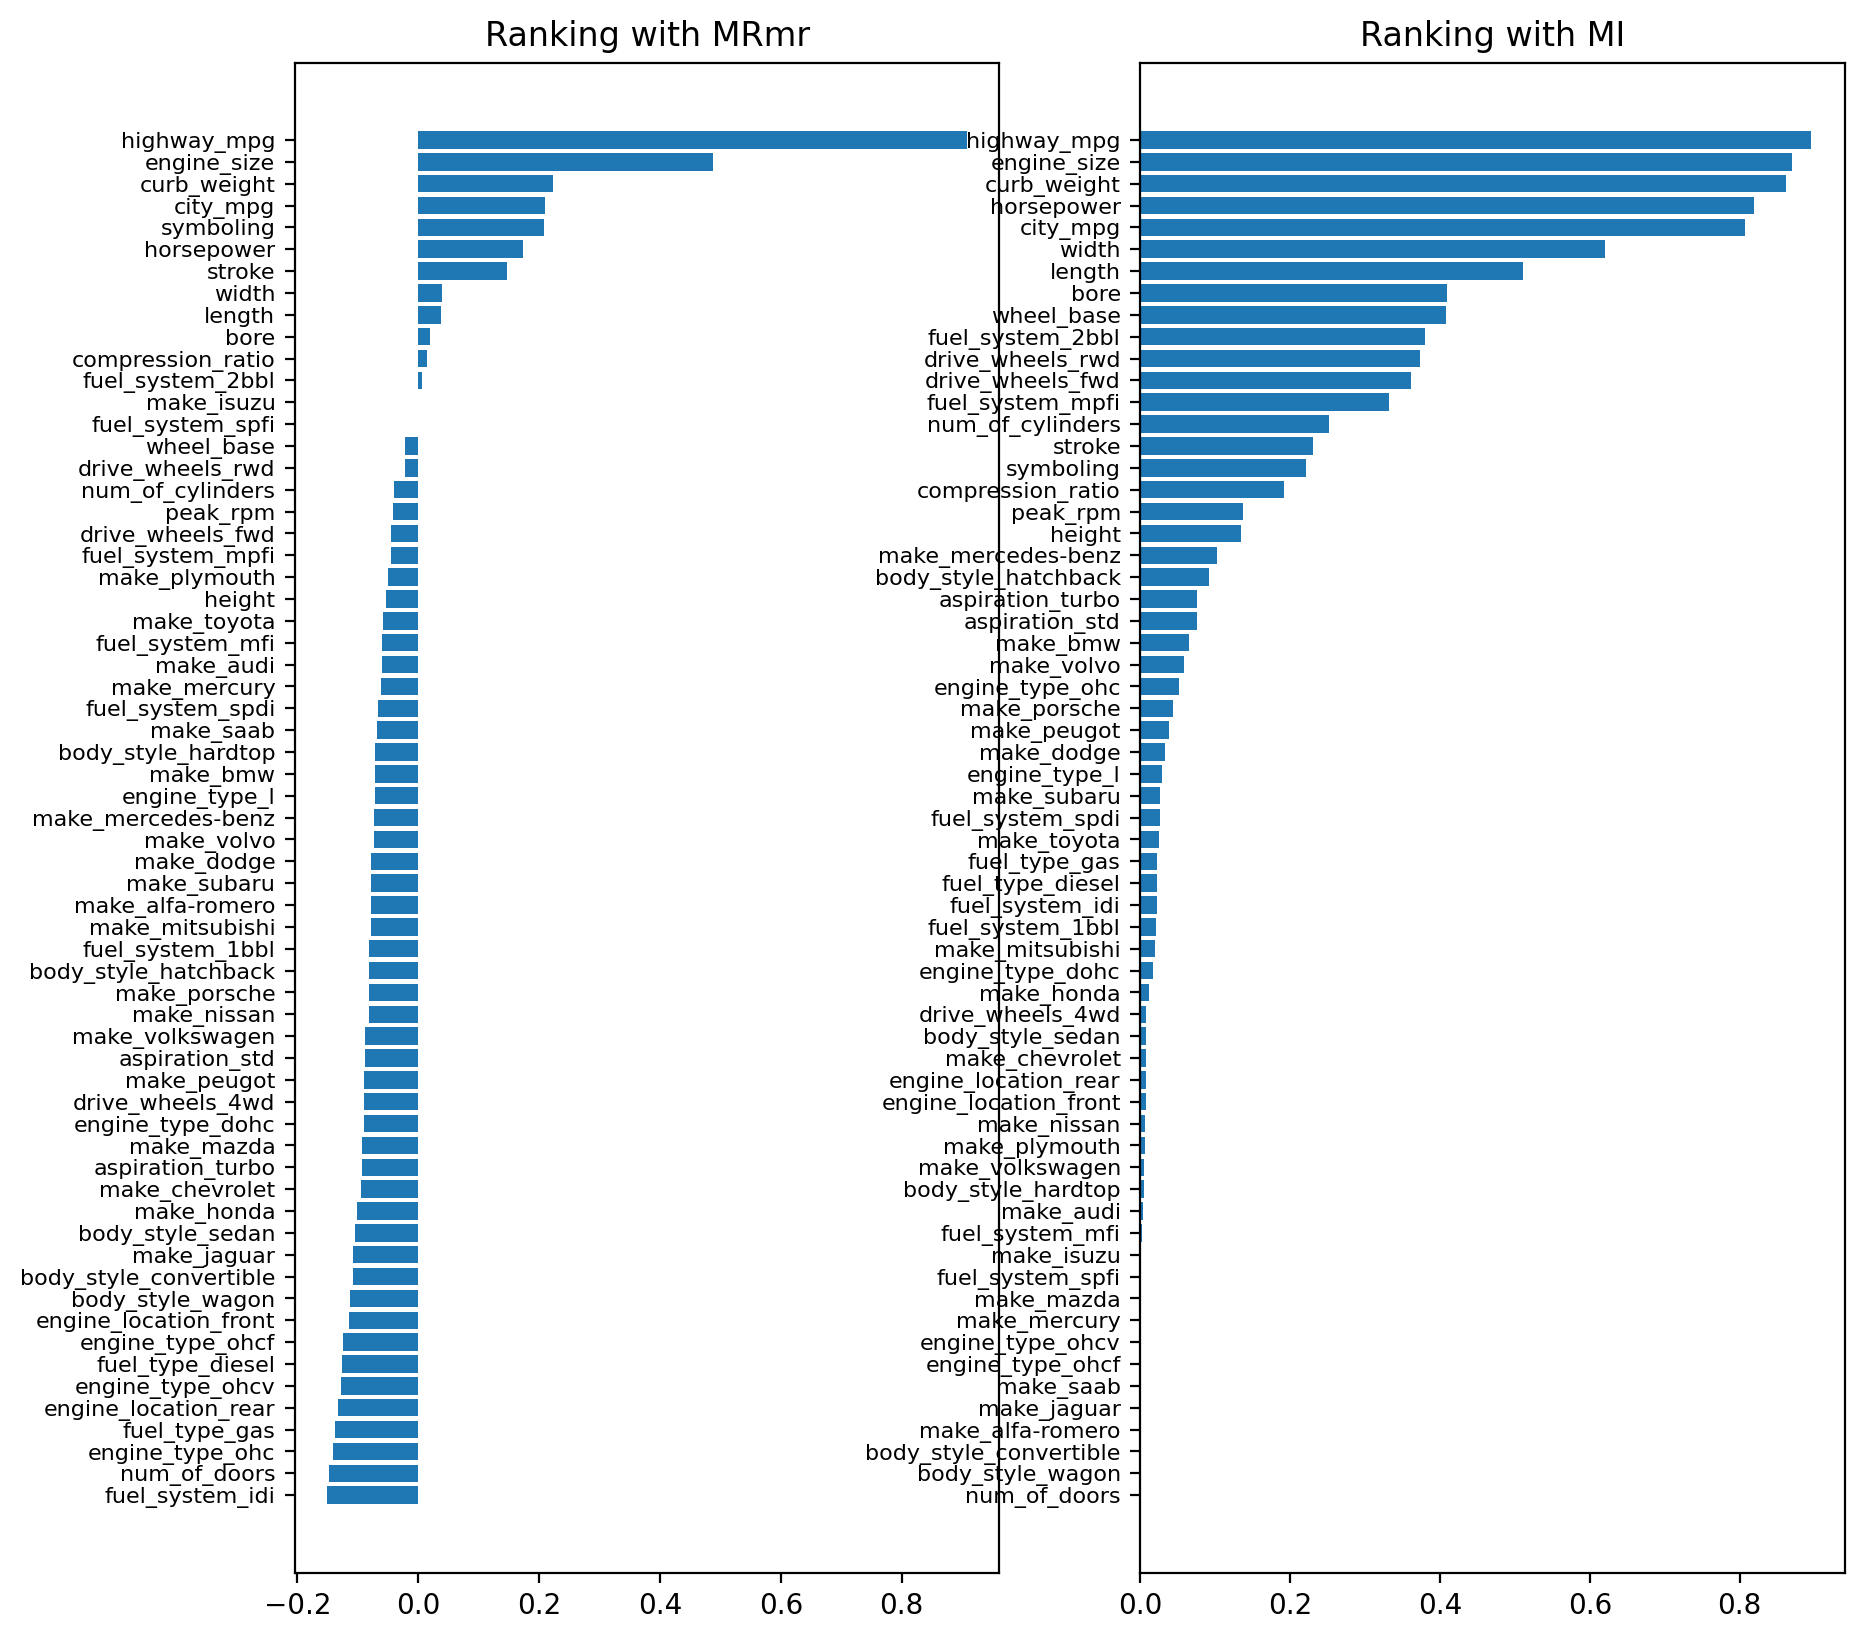

In [21]:
plt.figure(dpi=100, figsize=(10, 10))
plt.subplot(1,2,1)
plt.rc('ytick', labelsize=8) 
plot_utility_scores(mi_scores_MRmr, title="Ranking with MRmr")
plt.subplot(1,2,2)
plot_utility_scores(mi_scores, title="Ranking with MI")

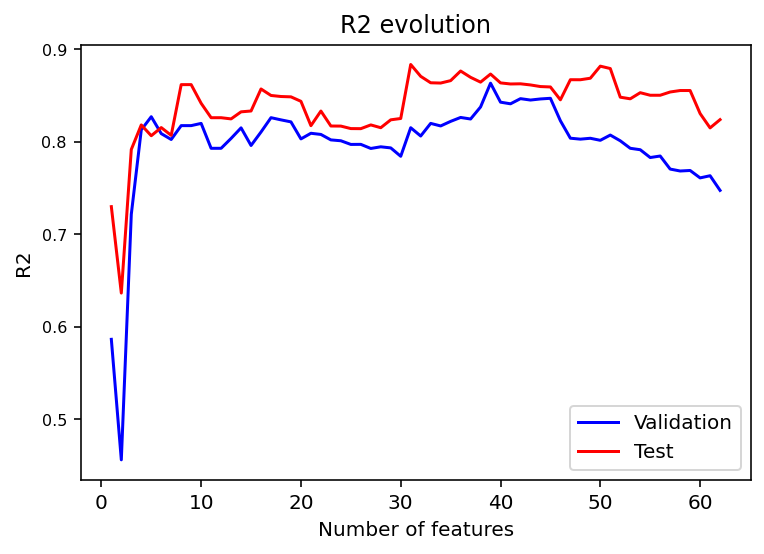

Number of selected features:  39
The test R2 is  0.87


In [22]:
# Define the range of features to explore
rang_feat = np.arange(1, X.shape[1]) 
[R2_val, R2_test] = R2_evolution(X_train[:, ind_rel_feat], Y_train, X_test[:, ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_R2_evolution(rang_feat, R2_val, R2_test)
plt.show()

# Find the CV number of features
pos_max = np.argmax(R2_val)
num_feat = rang_feat[pos_max]
test_R2 = R2_test[pos_max]

print('Number of selected features:  %d' %(num_feat))
print("The test R2 is  %2.2f" %(test_R2))

### Multivariate relevance measurements: Hilbert-Schmidt Independence Criterion (HSIC)
We can find in the literature proposals for relevance criteria working over subsets of features (for example, other MI implentations), but they usually degrate with large number of variables. One measurement that tends to work accuratelly in this scenarios is the Hilbert-Schmidt Independence Criterion (HSIC). The HSIC is a kernel extension of the correlation measurement.

If the covariance between two variables $\textbf{x}$ and $\textbf{y}$ is given by:
$$ {\mathcal C}_{xy} = {\mathbb E}_{xy}(\textbf{x}\textbf{y}^\top) - {\mathbb E}_{x}(\textbf{x}){\mathbb E}_{y}(\textbf{y}^\top) $$
We can extend the covariance definition to the Hilbert space by means of kernel functions: 
$${\mathcal C}_{xy} = {\mathbb E}_{xy}[(\phi(\textbf{x})-\mu_x)\otimes(\psi(\textbf{y})-\mu_y)]$$
where $\mu_x={\mathbb E}_{x}[\boldsymbol{\phi}(\textbf{x})]$, and $\mu_y={\mathbb E}_{y}[\boldsymbol{\psi}(\textbf{y})]$. 

The 2 norm over the covariance matrix computed in the Hilbert space, $\|{\mathcal C}_{xy}\|^2_{\text{HS}}$, provides the Hilbert-Schmidt Independence Criterion. In fact, this norm can be expressed in terms of kernel matrices as:
$$ \text{HSIC}(\textbf{X},\textbf{Y}) = 
\dfrac{1}{m^2} \text{Tr}(\tilde{K}_x \tilde{K}_y)$$
where $\tilde{K}_x$ y $\tilde{K}_y$ are the centered kernel matrices corresponding to variables $\textbf{X}$ and $\textbf{Y}$.

Next cell code implements this relevance criteria for you!

In [23]:
from sklearn.metrics.pairwise import rbf_kernel

def center_K(K):
    """Center a kernel matrix K, i.e., removes the data mean in the feature space.

    Args:
        K: kernel matrix                                        
    """
    size_1,size_2 = K.shape;
    D1 = K.sum(axis=0)/size_1 
    D2 = K.sum(axis=1)/size_2
    E = D2.sum(axis=0)/size_1

    K_n = K + np.tile(E,[size_1,size_2]) - np.tile(D1,[size_1,1]) - np.tile(D2,[size_2,1]).T
    return K_n

def HSIC_rbf(X, Y):
    """Compute HSIC value between input and output data using a RBF kernel"""
    if X.ndim==1:
        X=X[:,np.newaxis]
    if Y.ndim==1:
        Y=Y[:,np.newaxis]
    # 2. Compute kernel matrices
    K_x = rbf_kernel(X)
    K_y = rbf_kernel(Y)
    # 3. Center kernel matrices
    K_xc = center_K(K_x)
    K_yc = center_K(K_y)
    # 4. Compute HSIC value
    HSIC= float(np.multiply(K_xc,K_yc).sum().sum())/(K_x.shape[0]**2) ;
    #HSIC= float(np.trace(np.dot(K_xc,K_yc)))/(K_x.shape[0]**2) 
    return HSIC


Now, we can use it to get a ranking of variables...

In [24]:
# Compute HSIC relevances
importances=np.zeros(X_train.shape[1])
for i in range(X_train.shape[1]):
    importances[i]=HSIC_rbf(X_train[:,i], Y_train)
    
# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(importances)[::-1]

HSIC_scores = pd.Series(importances[ind_rel_feat], index =X.columns[ind_rel_feat]) 
HSIC_scores


city_mpg            0.004923
highway_mpg         0.004914
bore                0.004854
height              0.004817
curb_weight         0.004801
                      ...   
make_saab           0.000297
fuel_system_mfi     0.000150
make_mercury        0.000150
make_isuzu          0.000000
fuel_system_spfi    0.000000
Length: 63, dtype: float64

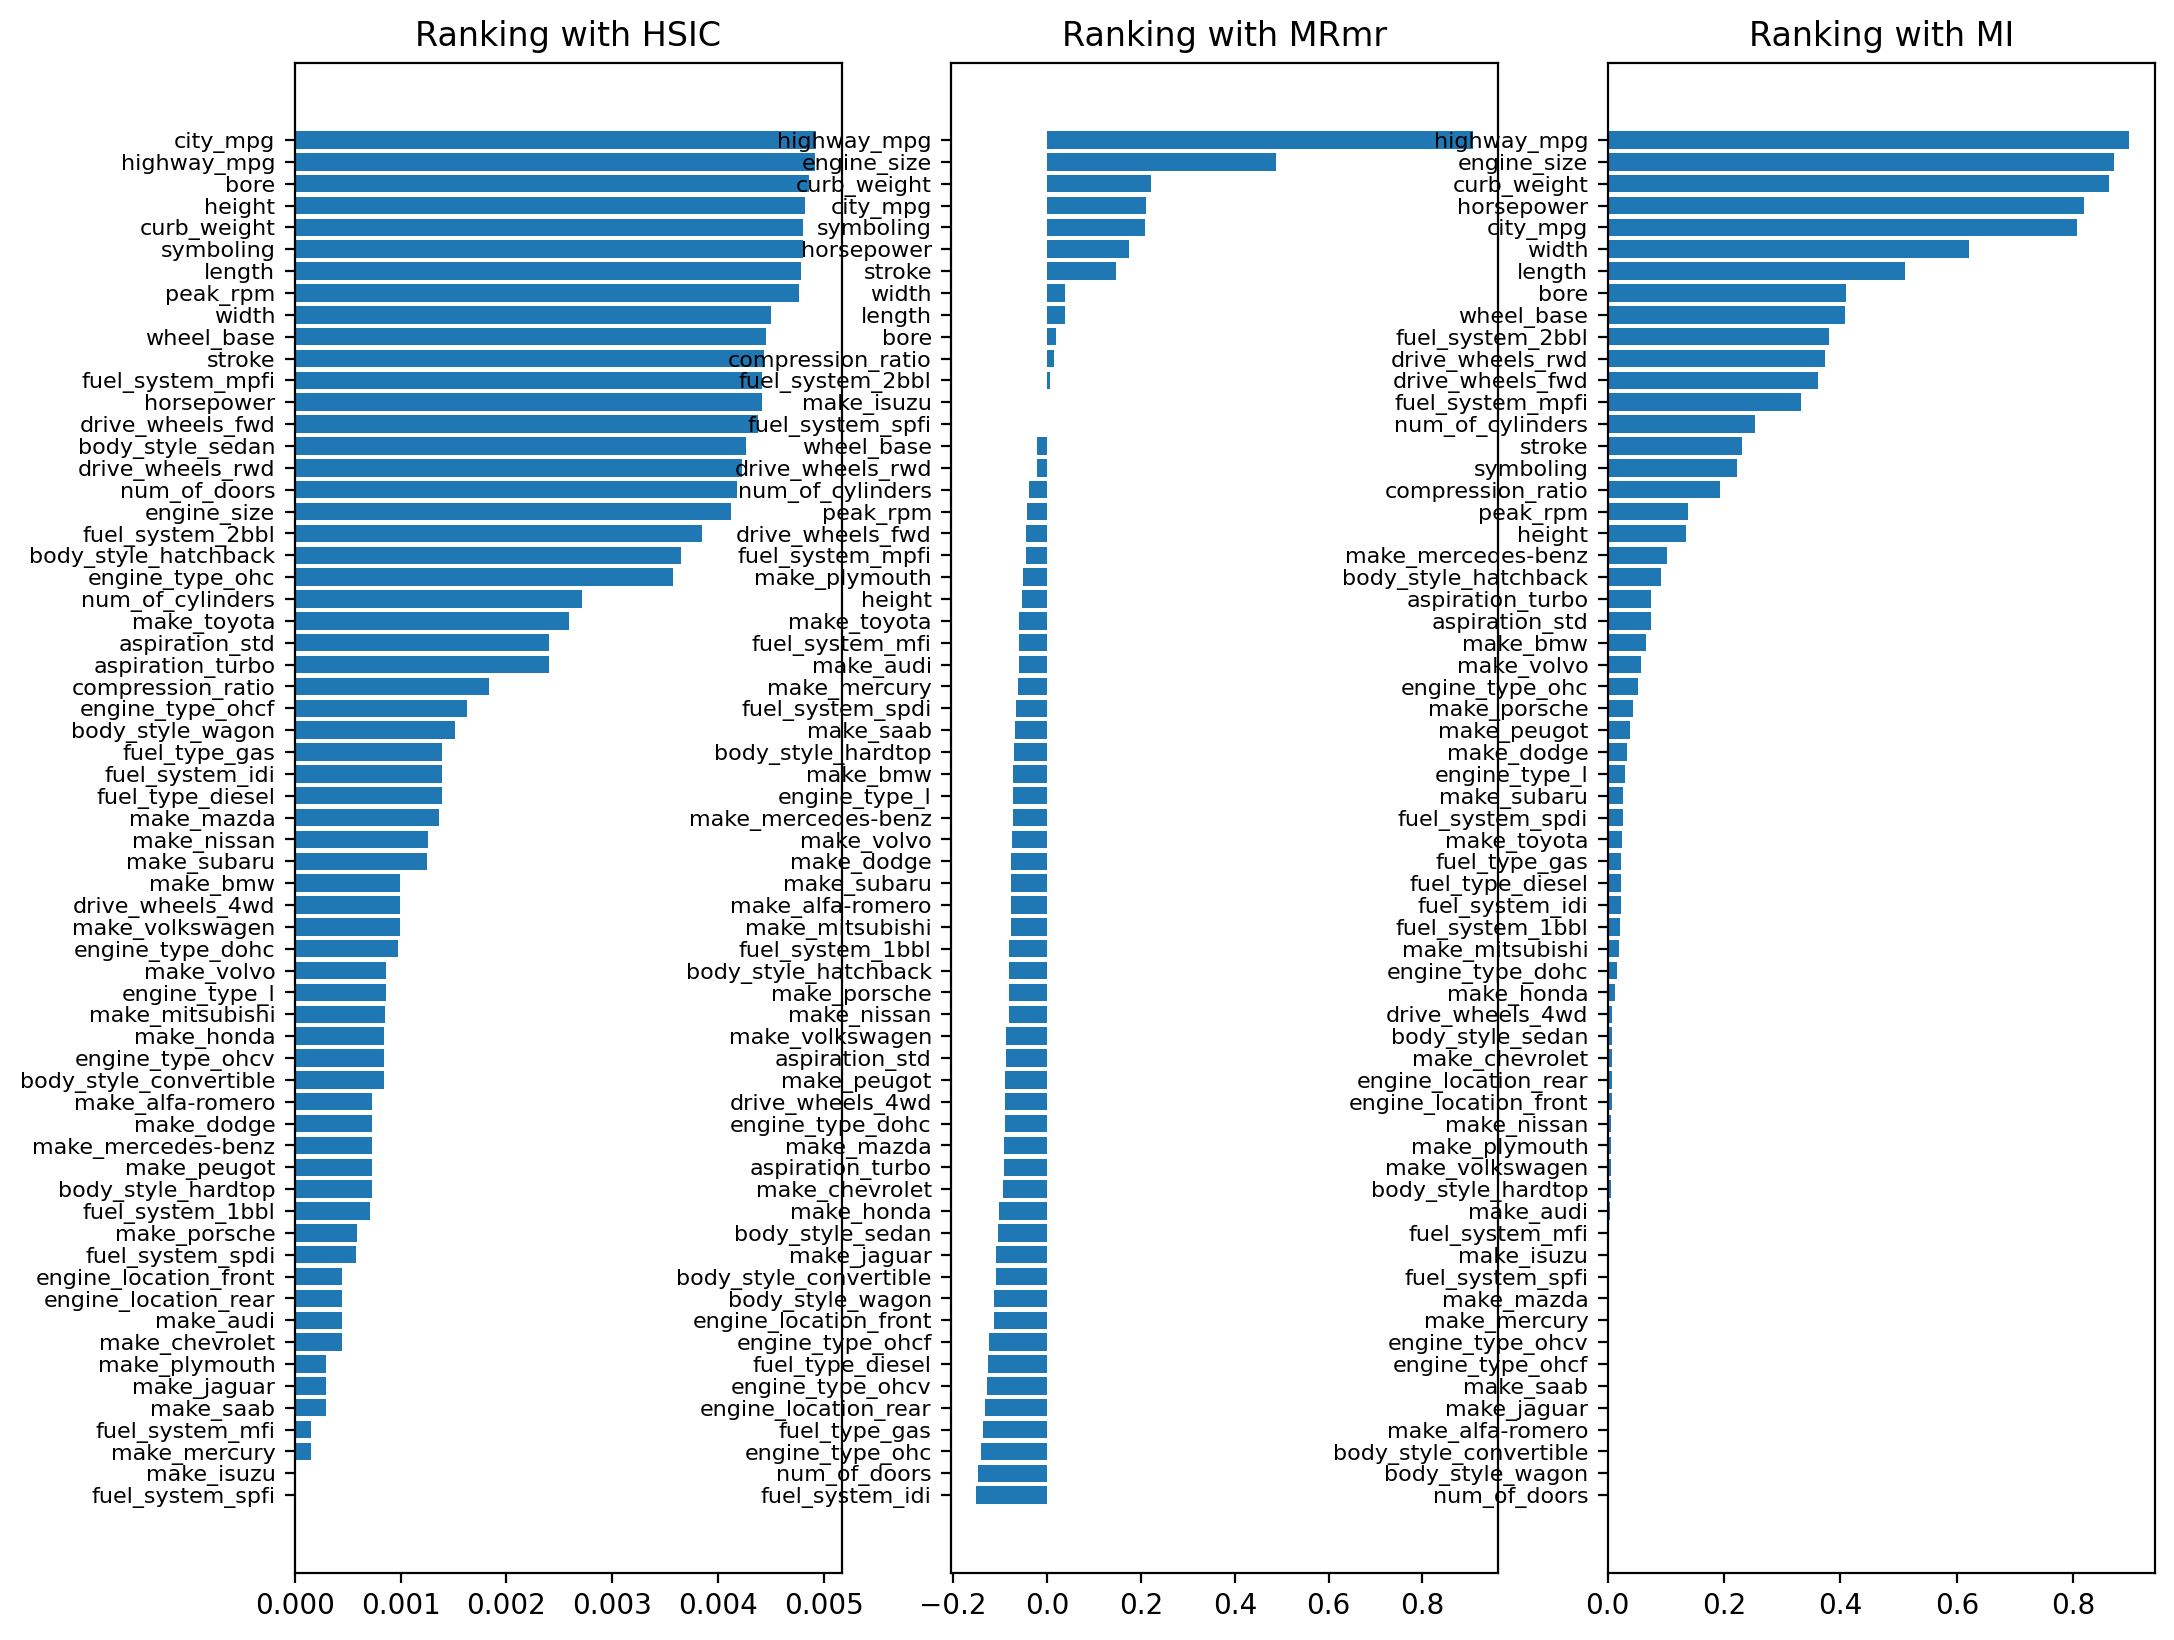

In [25]:
plt.figure(dpi=100, figsize=(12, 10))
plt.subplot(1,3,1)
plt.rc('ytick', labelsize=8) 
plot_utility_scores(HSIC_scores, title="Ranking with HSIC")
plt.subplot(1,3,2)
plot_utility_scores(mi_scores_MRmr, title="Ranking with MRmr")
plt.subplot(1,3,3)
plot_utility_scores(mi_scores, title="Ranking with MI")

Note that in this example we have used the HSIC as a univariate measure, but we can use it to compute relevances with subsets of input features. For instance, the HSIC for all `make` categories is: 

In [26]:
col_make = [pos for pos, col in enumerate(X.columns) if 'make' in col] 

HSIC_make = HSIC_rbf(X_train[:,col_make], Y_train)
# Output:  0.006805560188772545

However, to use this criteria in a multivariate way, we need to combine it with a search strategy...

### Search strategies

When we use univariate approaches, we can rank our features according its individual relevance and use these ranking to select the best K features. This is fast and effective when $N <<D$ (more variables than data). 

Whereas, in  multivariate approaches, if we want to find the best subset of needed features we should explore of all possible features subsets. However this exhaustive search is usually computationally unaffordable (with $D$ features we have $2^D-1$ possible subsets!!!). For these reason, greedy search are commonly used:
* **Forward search** where we start with an empty set and iteratively, add new features according to a relevance criterion. 

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/FeatureSelection/FS_2en.png" width="40%">

* **Backward search** or **Recursive Feature Elimination** where we start considering all the features and iteratively, remove features according to a relevance criterion.

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/FeatureSelection/FS_3en.png" width="40%">



Here we do not go any further in the implementation of these search methods with HSIC because you will be working on the homework...

# Wrapper methods

Wrapper methods directly use the performance of the final classifier/regressor to evaluate the discriminatory/regression capability of the different subsets of features. 

To do this, they have to use a validation partition (or n-fold CV process) to  analyze the relevance of the different input features in an iterative way; besides, they are usually  combined with search strategies to be applied in a multivariate way.

Some specific implementations use some classifier/estimator parameters that indicate the feature relevance. For instance, in linear models, the model weigths can be used as an indication of the feature relevance, the higher (absolute) weight, the most relevant the feature.

In fact, sklearn includes a wrapper implementation of the RFE for any classifier that has any feature relevance indicator, either model wights (`coef`) or directly `feature_importances_`. Next cell code shows how to use it!

In [27]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor()
selector = RFE(DT, n_features_to_select=10, step=1)
selector = selector.fit(X_train, Y_train)
# Print selected features
X.columns[selector.support_] 


Index(['wheel_base', 'length', 'width', 'curb_weight', 'engine_size',
       'horsepower', 'peak_rpm', 'highway_mpg', 'make_bmw',
       'drive_wheels_4wd'],
      dtype='object')

We can also obtain the ranking of all the variables. To do this we re-train the model but indicating that it chooses 100% of variables and in the `.ranking_` attribute we have what we are looking for.

In [28]:
selector = RFE(DT, n_features_to_select=1, step=1) 
selector = selector.fit(X_train, Y_train)
ranking_RFE = pd.Series(1./selector.ranking_, index =X.columns) 
ranking_RFE.sort_values()[::-1]

engine_size      1.000000
curb_weight      0.500000
horsepower       0.333333
length           0.250000
width            0.200000
                   ...   
make_subaru      0.016949
make_peugot      0.016667
make_saab        0.016393
make_plymouth    0.016129
make_porsche     0.015873
Length: 63, dtype: float64

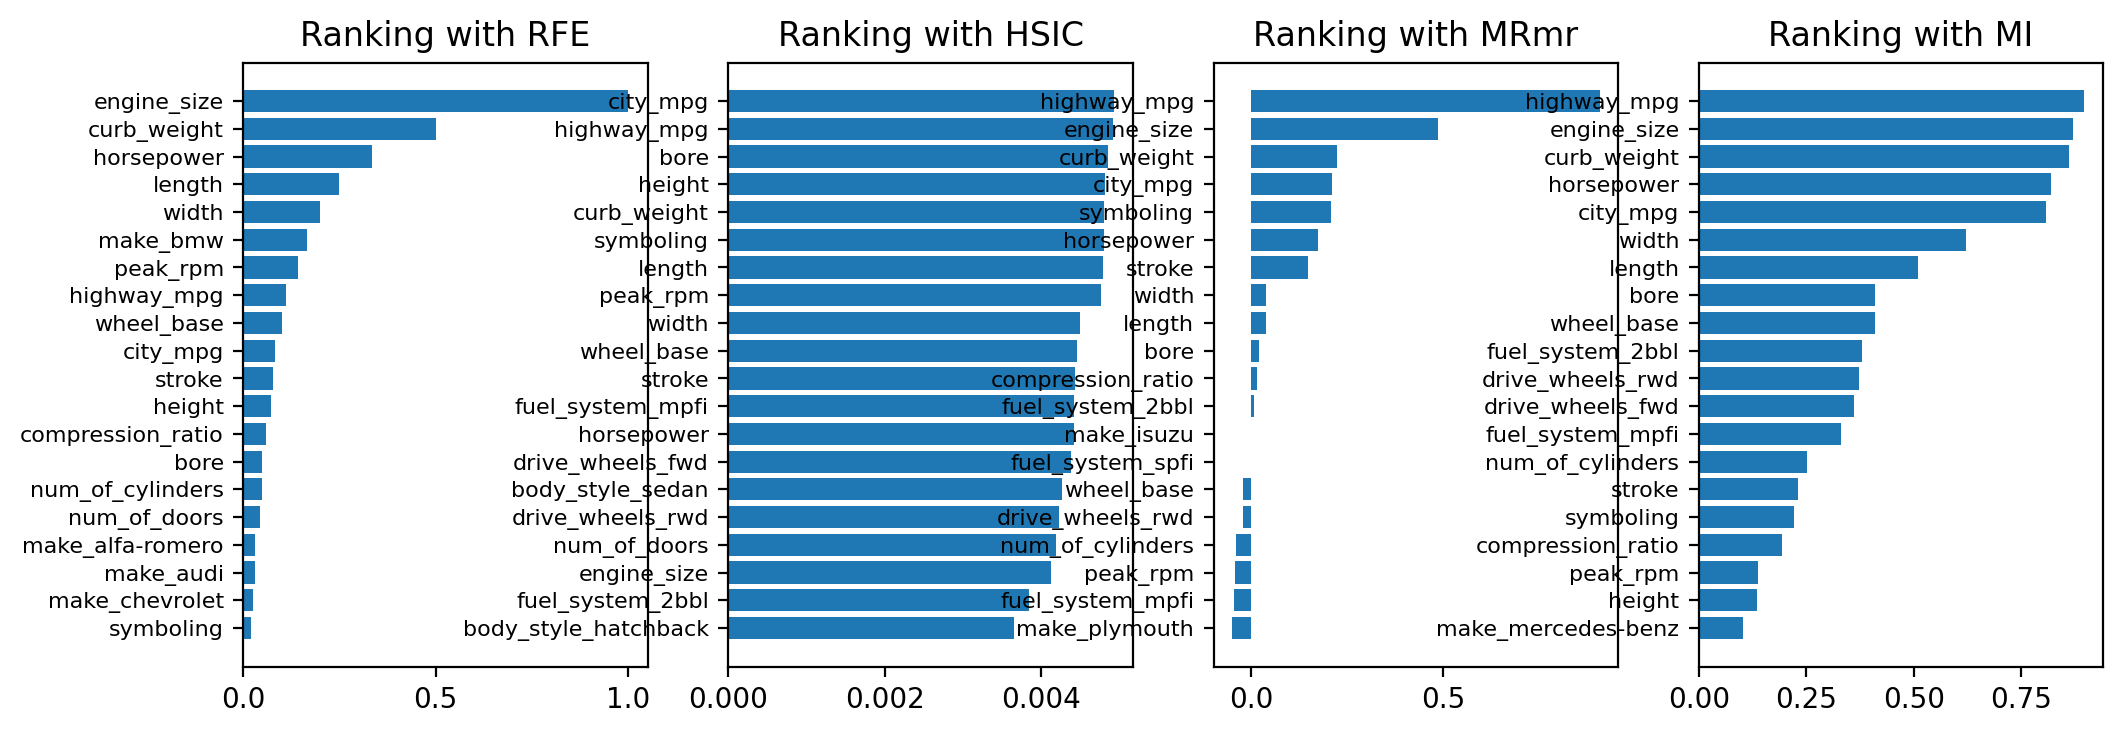

In [29]:
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1,4,1)
plt.rc('ytick', labelsize=8) 
plot_utility_scores(ranking_RFE[:20], title="Ranking with RFE")
plt.subplot(1,4,2)
plot_utility_scores(HSIC_scores[:20], title="Ranking with HSIC")
plt.subplot(1,4,3)
plot_utility_scores(mi_scores_MRmr[:20], title="Ranking with MRmr")
plt.subplot(1,4,4)
plot_utility_scores(mi_scores[:20], title="Ranking with MI")

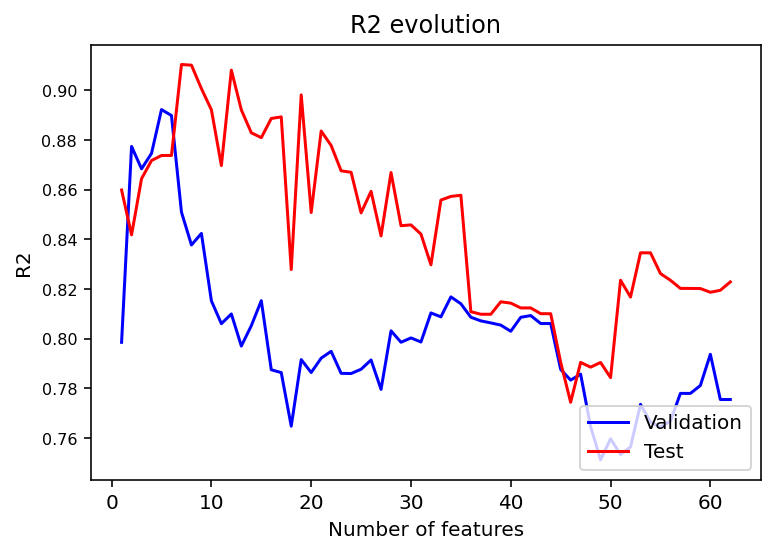

Number optimum of features:  5
The optimum test R2 is  0.87


In [30]:
# Define the range of features to explore
ind_rel_feat = np.argsort(selector.ranking_)
rang_feat = np.arange(1, X.shape[1]) 
[R2_val, R2_test] = R2_evolution(X_train[:, ind_rel_feat], Y_train, X_test[:, ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_R2_evolution(rang_feat, R2_val, R2_test)
plt.show()

# Find the optimum number of features
pos_max = np.argmax(R2_val)
num_opt_feat = rang_feat[pos_max]
test_R2_opt = R2_test[pos_max]

print('Number optimum of features:  %d' %(num_opt_feat))
print("The optimum test R2 is  %2.2f" %(test_R2_opt))

# Embedded methods

Embedded methods are able to carry out the feature selection process during the classifier training, so both stages (feature selection and classifier training) are completely linked and, therefore, the selection process is guided by the classifier.


Here, we are going to analyze two approaches: 
* Random Forests
* L1-regularization 

### Random Forest

As you know, a Random Forest (RF) trains several decision tree classifiers, where each one is trained with different samples and features of the training data, and averages their outputs to improve the final accuracy. 

We can use forests of trees to evaluate the importance of features on a classification task. Note that the relative rank (or depth) of a feature used by a decision node provides us a relative importance of that feature. Analyzing this information over all the trees of a RF, we can obtain a good estimation of predictive ability of each fature and use it for feature selection. 

The  [RandomForestClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) functions return the feature relevances in the variable `feature_importances_`. This variable is an array with shape `(n_features,)` whose values are positive and sum to 1.0. The higher the value, the more important is the contribution of the matching feature to the prediction function.


In [31]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(1)
# Build a forest and obtain the feature importances
forest = RandomForestRegressor(n_estimators=200)
forest.fit(X_train, Y_train)
importances = forest.feature_importances_
# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(importances)[::-1]
# Print the feature ranking
ranking_RF = pd.Series(importances[ind_rel_feat], index =X.columns[ind_rel_feat]) 
ranking_RF


engine_size         0.664638
curb_weight         0.168861
highway_mpg         0.037490
horsepower          0.017064
city_mpg            0.016902
                      ...   
make_mercury        0.000009
fuel_system_1bbl    0.000006
make_chevrolet      0.000003
make_isuzu          0.000000
fuel_system_spfi    0.000000
Length: 63, dtype: float64

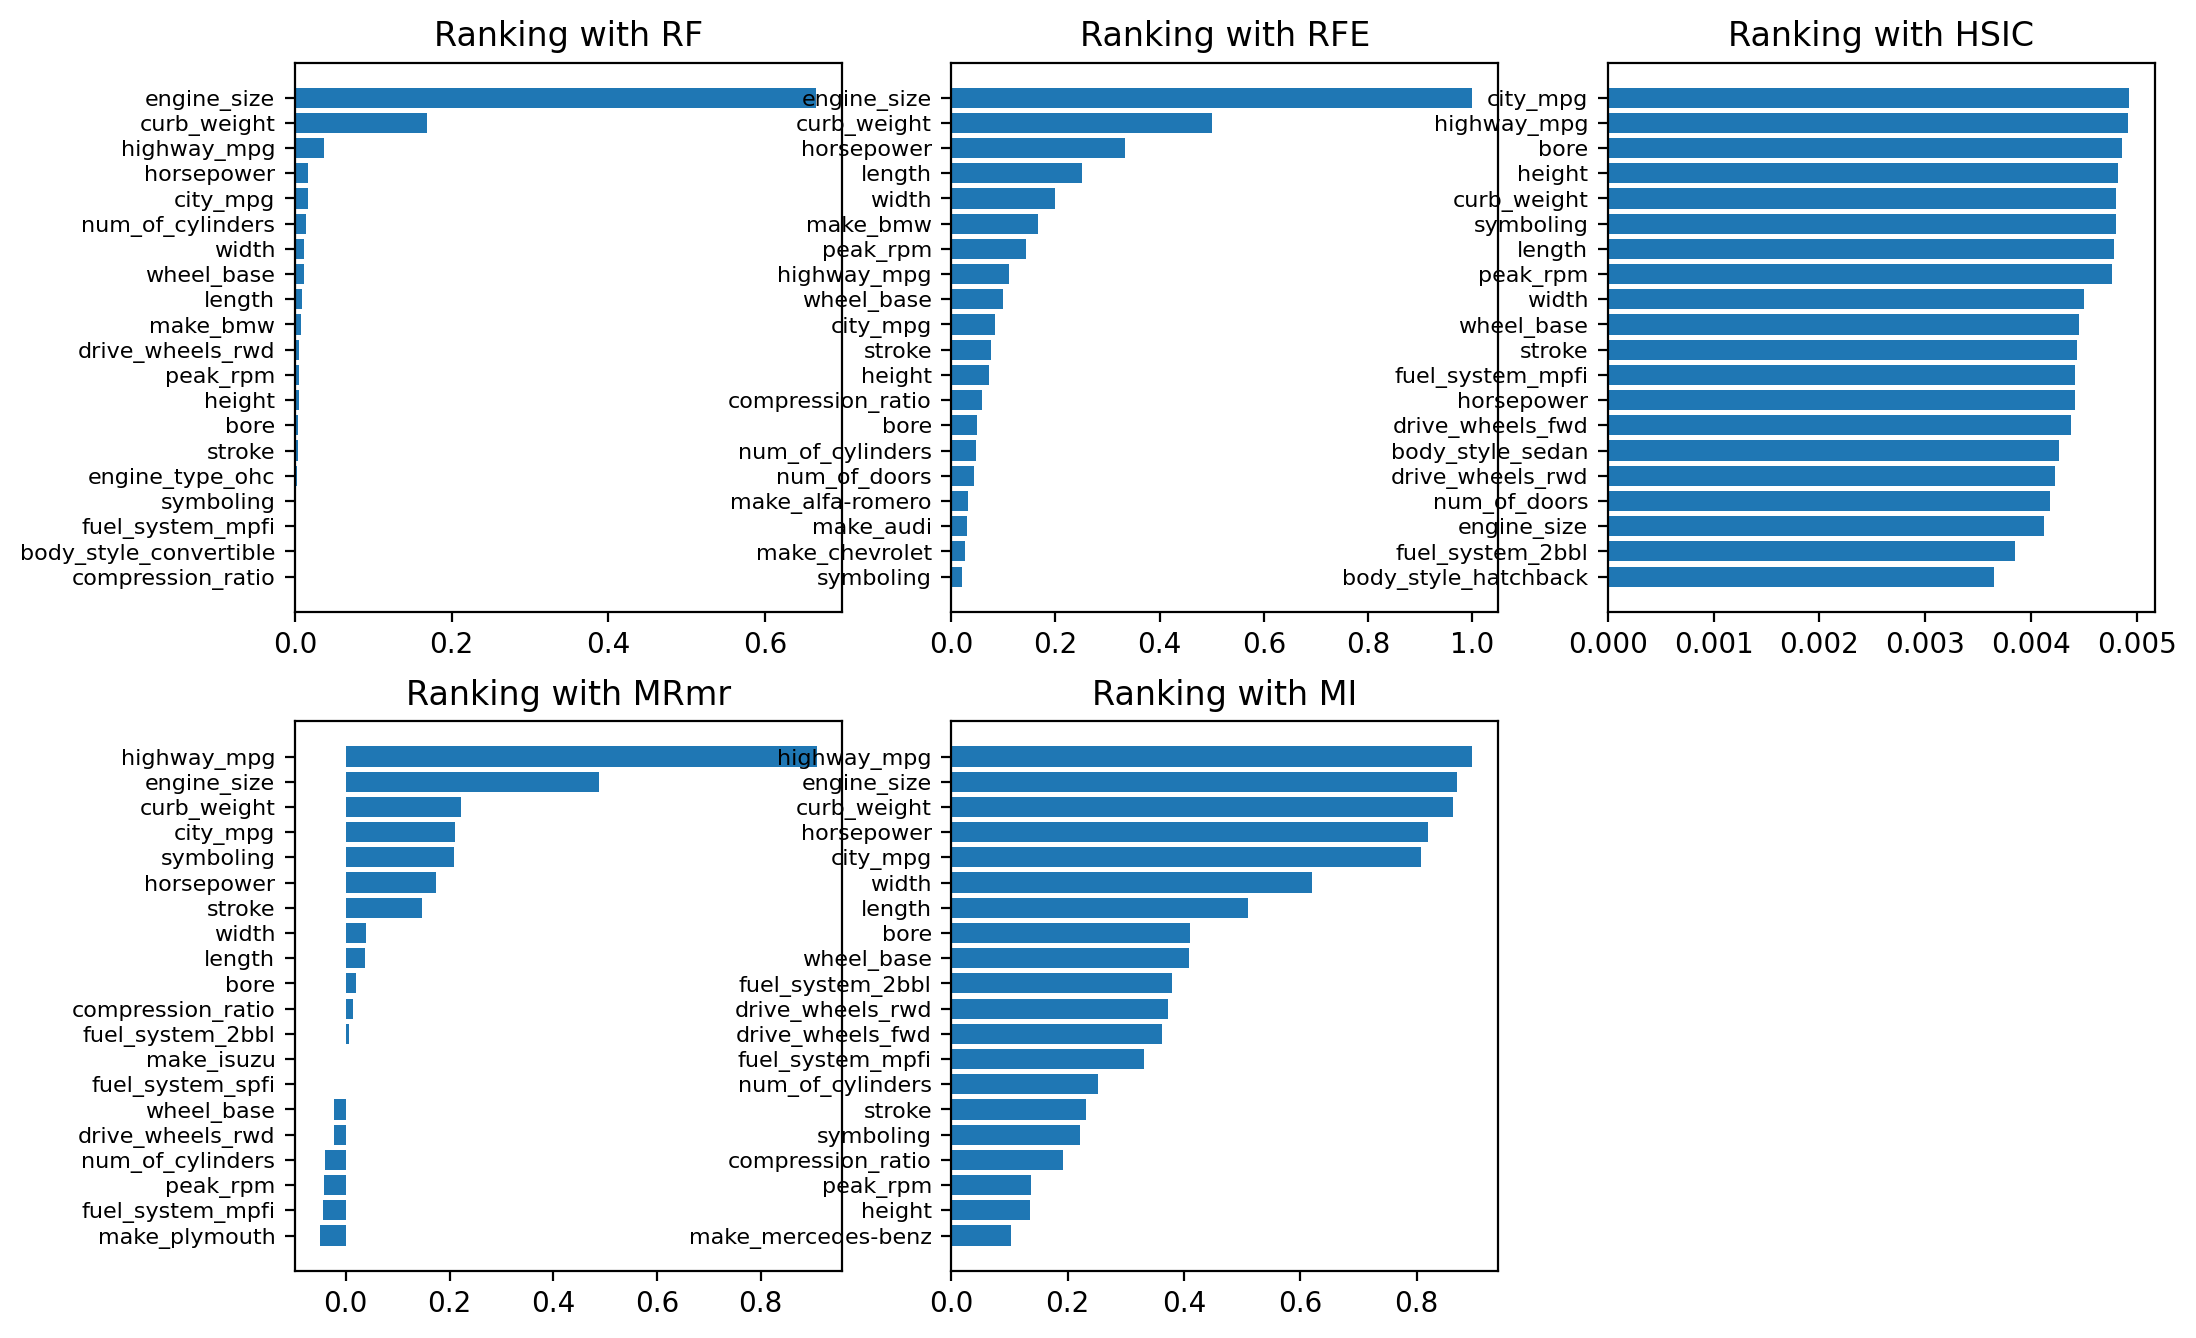

In [32]:
plt.figure(dpi=100, figsize=(12, 8))
plt.subplot(2,3,1)
plt.rc('ytick', labelsize=8) 
plot_utility_scores(ranking_RF[:20], title="Ranking with RF")
plt.subplot(2,3,2)
plot_utility_scores(ranking_RFE[:20], title="Ranking with RFE")
plt.subplot(2,3,3)
plot_utility_scores(HSIC_scores[:20], title="Ranking with HSIC")
plt.subplot(2,3,4)
plot_utility_scores(mi_scores_MRmr[:20], title="Ranking with MRmr")
plt.subplot(2,3,5)
plot_utility_scores(mi_scores[:20], title="Ranking with MI")

Note that this is not strictly a feature selection, as the final RF may actually use all features; however, this approach at least provides a feature ranking during the RF training and we can use it with a subsequent classifier... So, let's consider RF as a *semi-embedded* FS.

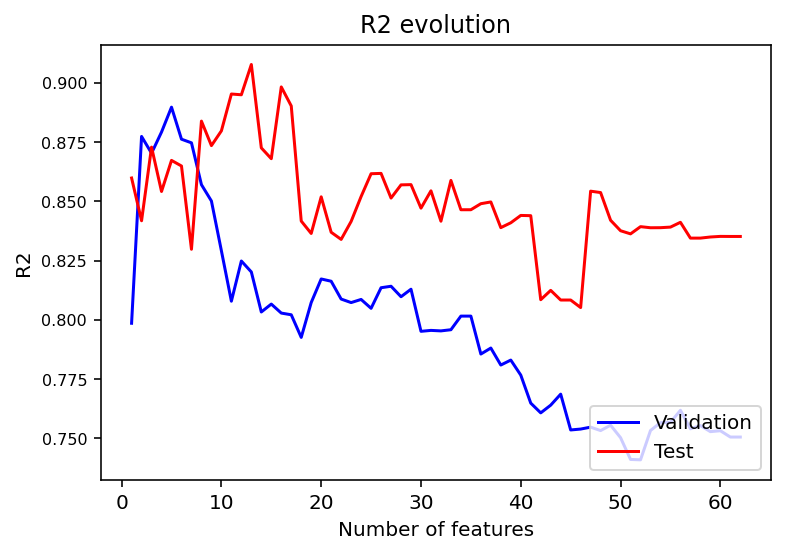

Number of features:  5
The test R2 is  0.87


In [33]:
# Define the range of features to explore
rang_feat = np.arange(1, X.shape[1]) 
[R2_val, R2_test] = R2_evolution(X_train[:, ind_rel_feat], Y_train, X_test[:, ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_R2_evolution(rang_feat, R2_val, R2_test)
plt.show()

# Find the CV number of features
pos_max = np.argmax(R2_val)
num_feat = rang_feat[pos_max]
test_R2 = R2_test[pos_max]

print('Number of features:  %d' %(num_feat))
print("The test R2 is  %2.2f" %(test_R2))

### L1 regularization

As you know, many ML models use regularization terms to avoid model overfitting. While the most common regularization is the L2 penalty, L1 constrain causes some of the coefficients drop to zero. Thus, the $L_1$ regularization does a kind of feature selection. For this reason, this regularization is known as LASSO (Least Absolute Shrinkage and Selection Operator).

Let's consider a regularized linear regresion model, with L2 (Ridge Regression) and L1 (Lasso) regularizations, to analyze this property. To do this, let's reformulate their formulations as a least squares optimization problem plus a constraint, that is,

* **Ridge regression**:

$$\mathbf{w}^* = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{i=1}^{N} (y^{(i)}-\mathbf{w}^T\mathbf{x}^{(i)})^2 $$
$$ {\rm s.t.} \sum_{j=1}^{D} {w}_j^2 \leq t$$

* **Lasso regression**:


$$\mathbf{w}^*= \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{i=1}^{N} (y^{(i)}-\mathbf{w}^T\mathbf{x}^{(i)})^2 $$
$$ {\rm s.t.} \sum_{j=1}^{D} | w_j| \leq t$$

In this way we can see that these problems are really minimizing the mean squared error and, at the same time, they are forcing the values of $\mathbf{w}$ to be within the region defined by the constraint. In the case of L2, this constraint forces $\mathbf{w}$ to fall inside a sphere of radius $\sqrt{t}$ and in the case of L1 this region is a diamond of side $\sqrt{2}t$. Next figure (from [1]) depicts these optimization problems for a two dimensional problem (the ridge regression on the left and  lasso  on the right).

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/vL1_l2.png" width="50%" > 

Note that both methods find the optimal solution where the elliptical contours (mean squared error) hit the constraint region. However, the lasso constraint has corners and when the solution falls into a corner, the value of $w_j$ becomes zero. When there are many input dimensions, the diamond becomes a rhomboid with many corners, flat edges and faces, increasing the chances for the estimated parameters to be zero.



The code in the next cell analyses the properties of the L1 regularization as a feature selector for a linear regression model. In particular, it uses the implementation given by the `Lasso` method.

Unlike the previous methods, here we cannot obtain a ranking of variables. In this case, we have to sweep the value of the regularization parameter (`alpha`) to obtain a higher (or lower) dispersion of the vector of weights. 



In [34]:
from sklearn.linear_model import Lasso

# Defining some useful variables to save results
R2_test = []
num_feat = []

# Defining the range of C values to explore
rang_alpha = np.logspace(-2, 2, 20)

for i, alpha in enumerate(rang_alpha):
    # Define and train LASSO
    model = Lasso(alpha=alpha, max_iter=50000)
    model.fit(X_train, Y_train)
    
    # Compute the number of selected features (coef_l1 contains zeros due to the
    # L1 sparsity inducing norm)
    coef_l1 = model.coef_
    num_feat.append(np.sum(coef_l1 == 0))
    
    # Compute accuracies
    R2_test.append(model.score(X_test, Y_test))


c:\users\sergi\desktop\university\2. machine learning applications\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2610239.5717529356, tolerance: 835864.4556695651
  model = cd_fast.enet_coordinate_descent(


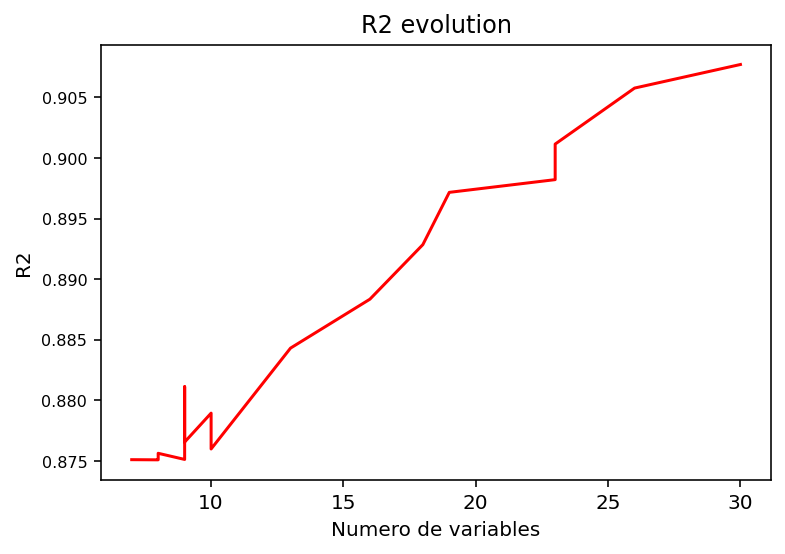

In [35]:
# Plot the accuracy curves
plt.figure()
num_feat = np.array(num_feat)
R2_test = np.array(R2_test)
id_sort = np.argsort(num_feat)
plt.plot(num_feat[id_sort], R2_test[id_sort], "r", label="test")
plt.xlabel("Numero de variables")
plt.ylabel("R2")
plt.title('R2 evolution')
plt.show()

In this case it is not so clear to define the ranking of variables, but by directly applying a `GridSearch` we can select the value of `alpha` and obtain at once the regressor together with the selected variables. 

In [36]:
# Defining the range of C values to explore
param_grid = {
    'alpha': rang_alpha
    }
model = Lasso(max_iter=1e5)
grid= GridSearchCV(model, param_grid, cv=10)
grid.fit(X_train, Y_train)
R2_test = grid.score(X_test, Y_test)
print(grid.best_params_)
coef_l1 = grid.best_estimator_.coef_
print('Número de variables seleccionadas:  %d' %(np.sum(coef_l1 == 0)))
print("Valor de R2 en test  %2.2f" %(R2_test))

{'alpha': 100.0}
Número de variables seleccionadas:  30
Valor de R2 en test  0.91


In [68]:
# # Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(coef_l1)[::-1]
# # Print the feature ranking
ranking_Lasso = pd.Series(coef_l1[ind_rel_feat], index =X.columns[ind_rel_feat]) 
ranking_Lasso

curb_weight              2673.152220
make_bmw                 2024.477122
engine_size              1574.554265
make_mercedes-benz       1139.256291
width                    1060.093222
                            ...     
symboling                -191.500270
make_mitsubishi          -281.176923
make_toyota              -374.364210
make_peugot              -436.537004
engine_location_front   -1578.493234
Length: 63, dtype: float64

As we can see, it is the model with the best performance, although at the cost of using a larger number of variables. However, we must not forget that the limitation of Lasso is that it only provides us with linear models and only selects variables that are linearly related to the output.

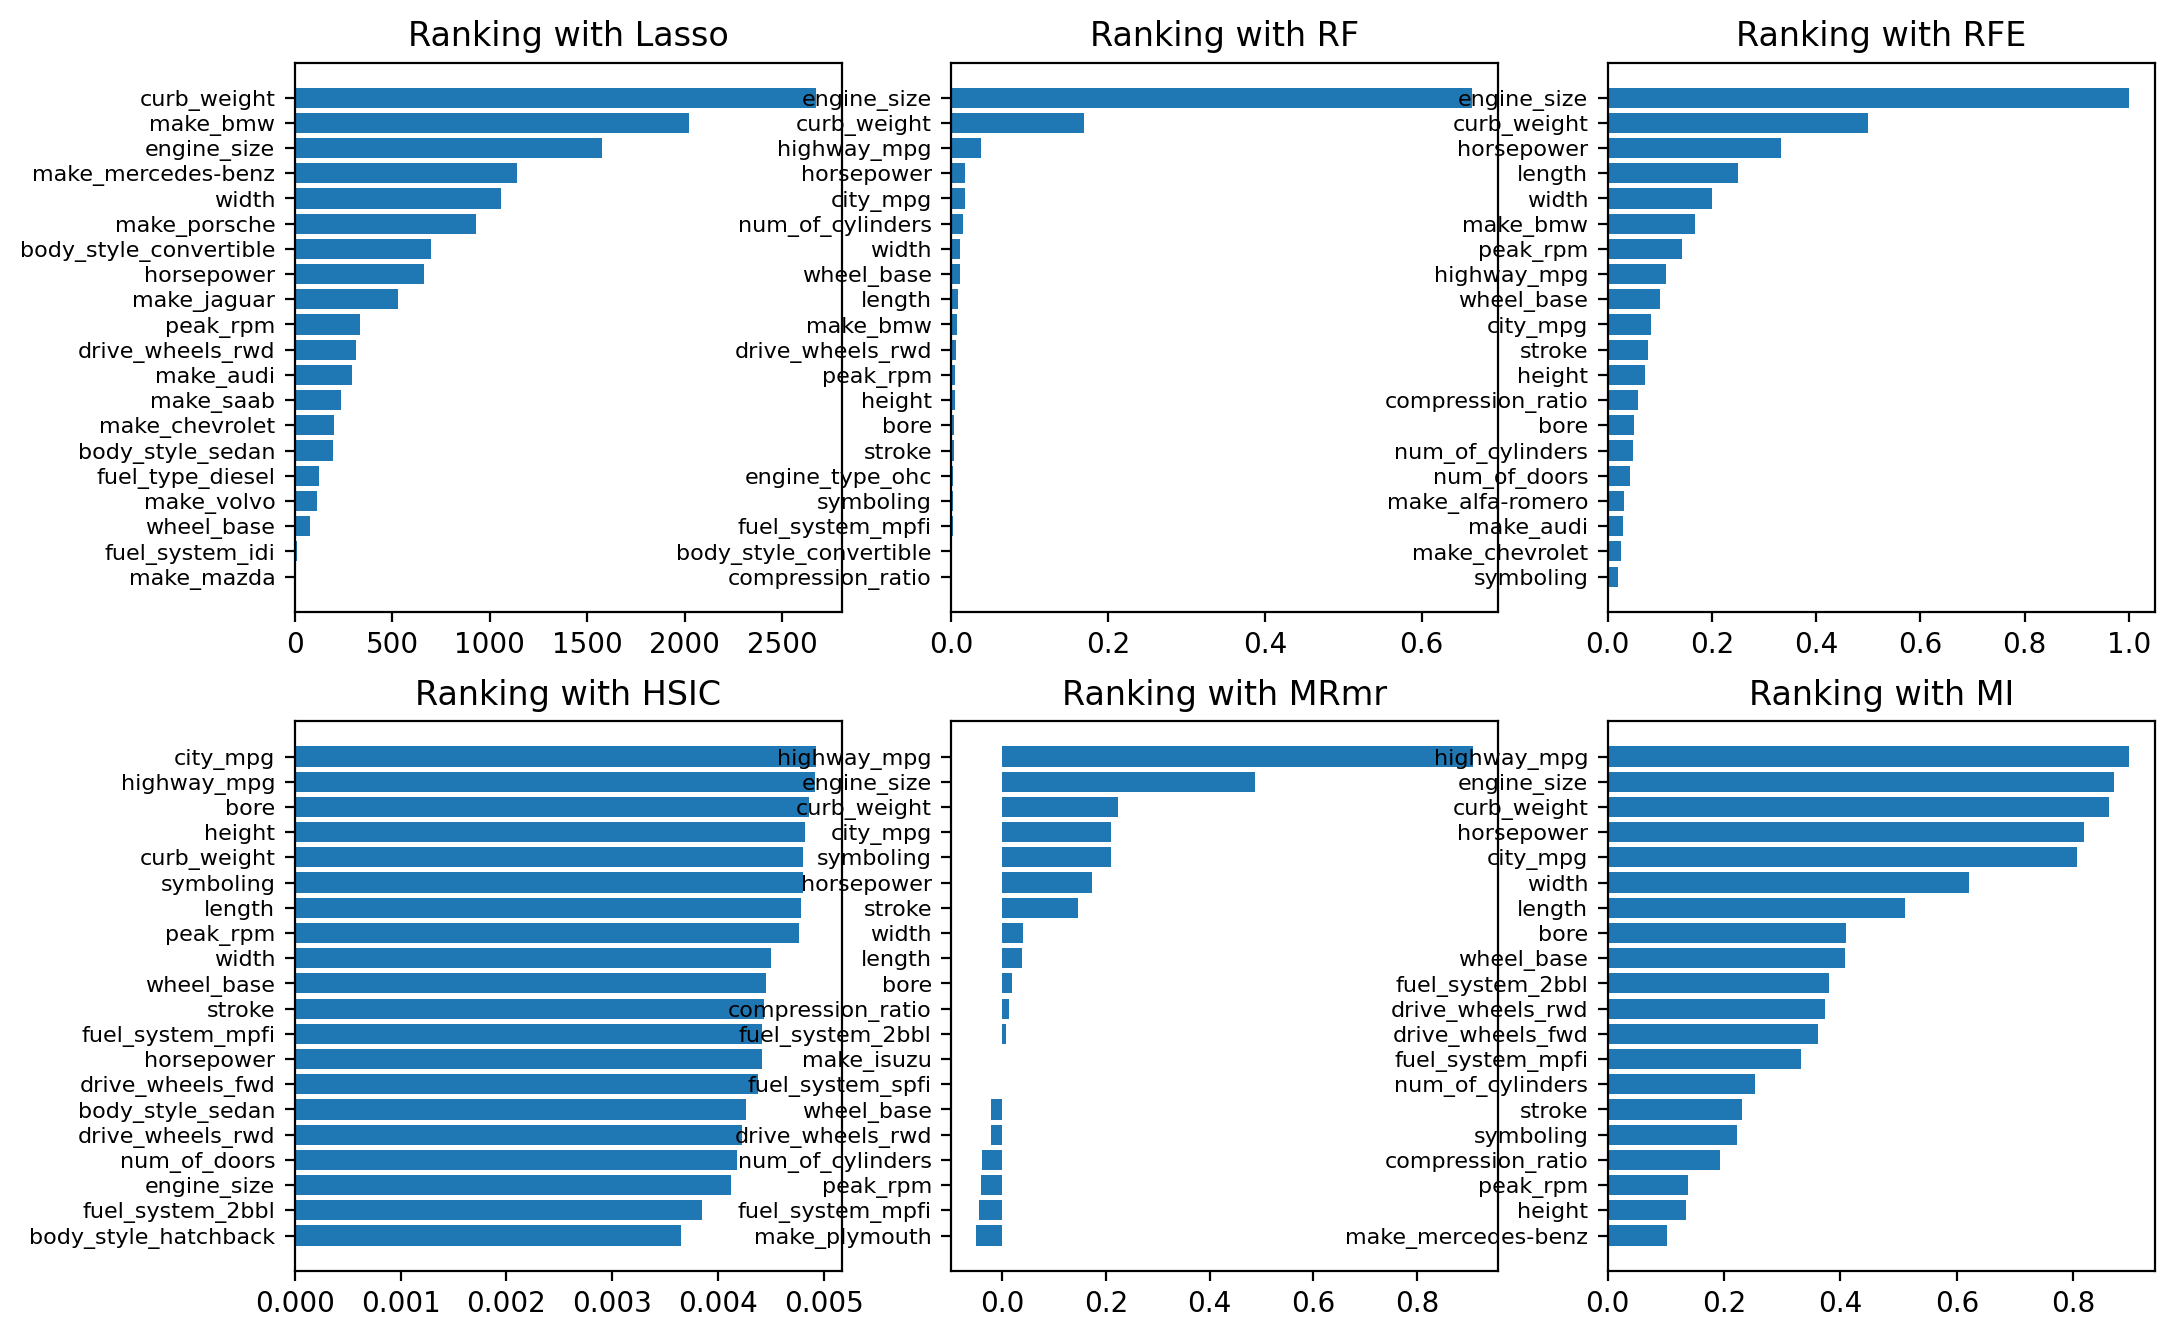

In [69]:
plt.figure(dpi=100, figsize=(12, 8))
plt.subplot(2,3,1)
plt.rc('ytick', labelsize=8) 
plot_utility_scores(ranking_Lasso[:20], title="Ranking with Lasso")
plt.subplot(2,3,2)
plot_utility_scores(ranking_RF[:20], title="Ranking with RF")
plt.subplot(2,3,3)
plot_utility_scores(ranking_RFE[:20], title="Ranking with RFE")
plt.subplot(2,3,4)
plot_utility_scores(HSIC_scores[:20], title="Ranking with HSIC")
plt.subplot(2,3,5)
plot_utility_scores(mi_scores_MRmr[:20], title="Ranking with MRmr")
plt.subplot(2,3,6)
plot_utility_scores(mi_scores[:20], title="Ranking with MI")